# 01 — Preselect & Diagnostics (CAPE / CIN / Shear)
This notebook **does not run WRF**. It builds or reads soundings, computes diagnostics (MLCAPE, MLCIN, 0–1 km and 0–6 km bulk shear, PW), and visualizes **ranges and coverage**.

**Modes:**
1. *Analytic generator* (`src/envgen_analytic.py`) using Saltelli samples of `u∈[0,1]^10`.
2. *Folder mode*: read existing WRF-ready `input_sounding_*` files (columns: p[hPa], T[K], qv[g/kg], u, v, z[m]).

The goal is to explore **full distributions** — not just a low‑CAPE/high‑shear subset.

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.insert(0, str(SRC))

from envgen_analytic import generate_sounding, diagnostics as env_diagnostics
try:
    from SALib.sample import saltelli
    HAS_SALIB = True
except Exception:
    HAS_SALIB = False


In [2]:
# --- CONFIG ---
MODE = 'folder'   # 'analytic' to generete here or 'folder' read precomputed soundings
N_SAMPLES = 512     # used when MODE='analytic' and SALib is available
U_CSV = None        # optional: path to CSV of u∈[0,1]^10 to bypass SALib
SOUNDINGS_DIR = str(REPO_ROOT / 'outputs' / 'soundings')  # used when MODE='folder'
OUT_CATALOG = str(REPO_ROOT / 'outputs' / 'env_catalog.csv')
os.makedirs(Path(OUT_CATALOG).parent, exist_ok=True)


In [3]:
def read_input_sounding(path):
    arr = np.loadtxt(path, comments='#', skiprows=1)
    p, T, qv, u, v, z = arr.T
    return dict(p=p, t=T, qv=qv, u=u, v=v, height=z)


In [4]:
# --- Build diagnostics catalog ---
rows = []
if MODE == 'analytic':
    if U_CSV is not None:
        U = np.loadtxt(U_CSV, delimiter=',')
        U = U if U.ndim==2 else U[None,:]
    elif HAS_SALIB:
        problem = {'num_vars': 10, 'names': [f'u{i}' for i in range(10)], 'bounds': [[0,1]]*10}
        U = saltelli.sample(problem, N_SAMPLES, calc_second_order=False)
    else:
        # simple fallback: random U in [0,1]^10
        U = np.random.rand(N_SAMPLES, 10)
    for i, u in enumerate(U):
        s = generate_sounding(u.tolist())
        d = env_diagnostics(s)
        rows.append({'idx': i, **d})
elif MODE == 'folder':
    files = sorted(glob.glob(os.path.join(SOUNDINGS_DIR, 'input_sounding_*')))
    if not files:
        raise SystemExit('No input_sounding_* files found in SOUNDINGS_DIR')
    for i, fp in enumerate(files):
        s = read_input_sounding(fp)
        d = env_diagnostics(s)
        rows.append({'idx': i, **d})
else:
    raise ValueError('Unknown MODE')

df = pd.DataFrame(rows)
df.to_csv(OUT_CATALOG, index=False)
df.describe(include='all')

,idx,MLCAPE,MLCIN,SH06,SH01,PW
count,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000,6144.000000
mean,3071.500000,2254.240898,-21.598004,21.746100,7.013689,48.841685
std,1773.764359,1640.051082,9.653622,9.702957,3.206204,8.994247
min,0.000000,0.000000,-67.293906,5.002220,0.985086,30.840123
25%,1535.750000,959.523360,-28.116840,13.899647,4.644738,41.457884
50%,3071.500000,1910.551508,-20.036863,20.504977,6.605305,48.131487
75%,4607.250000,3219.952608,-13.911444,28.264492,8.928023,55.487909
max,6143.000000,8356.278119,0.000000,44.892009,20.679016,76.335635


## Distributions — CAPE, |CIN|, and Shear
These give you the **ranges** covered by your design. CIN is plotted as absolute value.

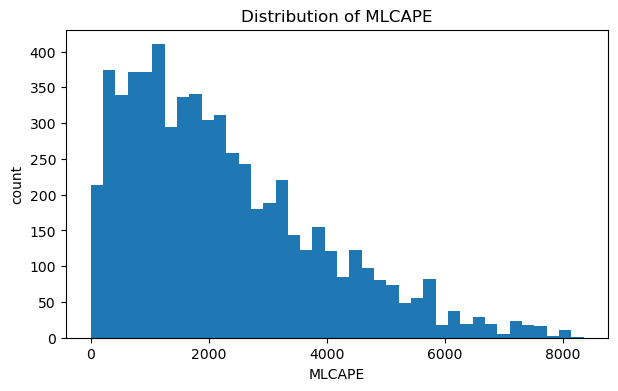

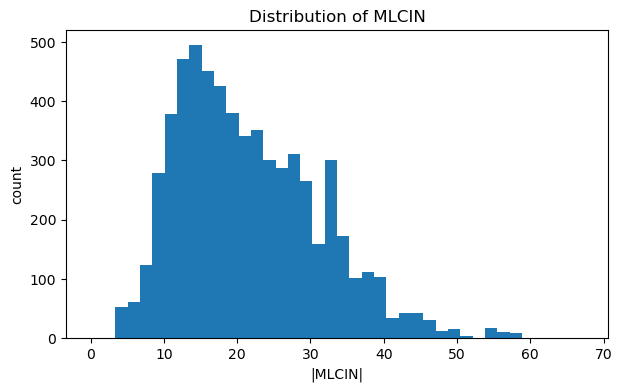

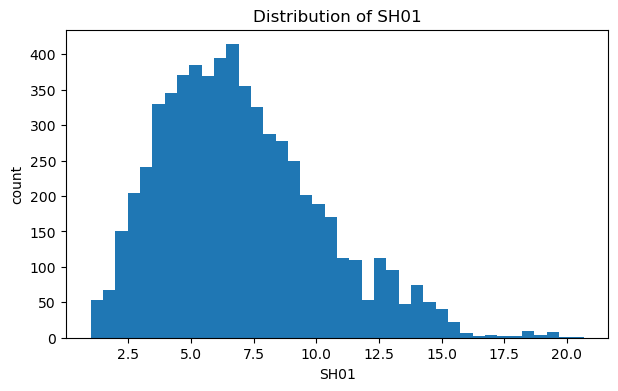

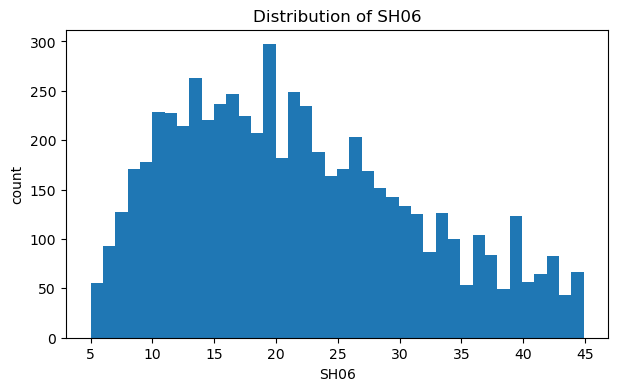

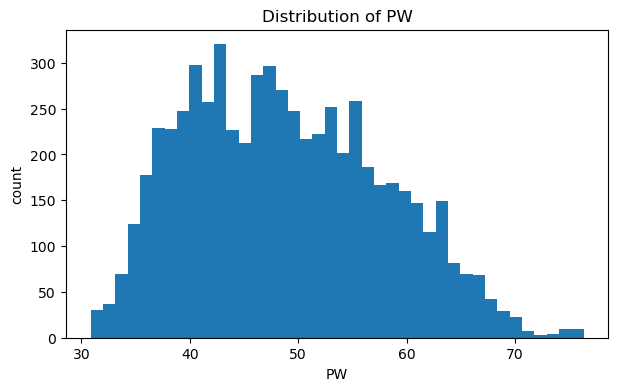

In [5]:
for col in ['MLCAPE','MLCIN','SH01','SH06','PW']:
    if col not in df.columns: continue
    vals = np.abs(df[col]) if col=='MLCIN' else df[col]
    plt.figure(figsize=(7,4))
    plt.hist(vals.dropna().values, bins=40)
    plt.xlabel(col if col!='MLCIN' else '|MLCIN|')
    plt.ylabel('count')
    plt.title(f'Distribution of {col}')
    plt.show()


## 2‑D Coverage (hexbin)
Quick maps to see where samples land: **CAPE vs shear**, and **CAPE vs |CIN|**.

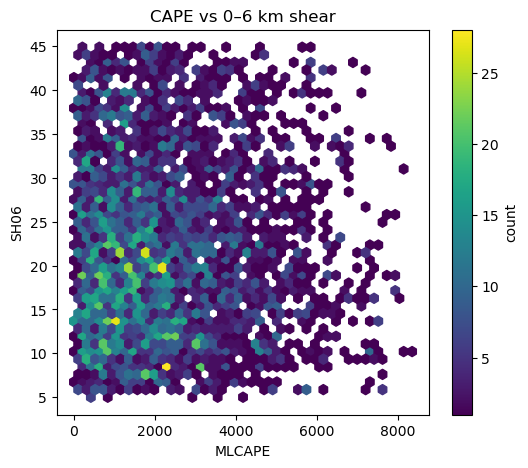

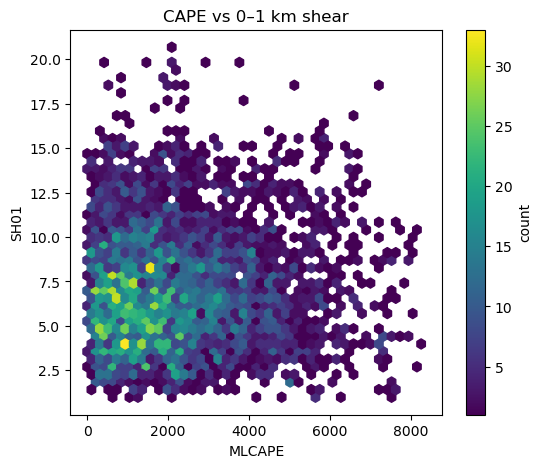

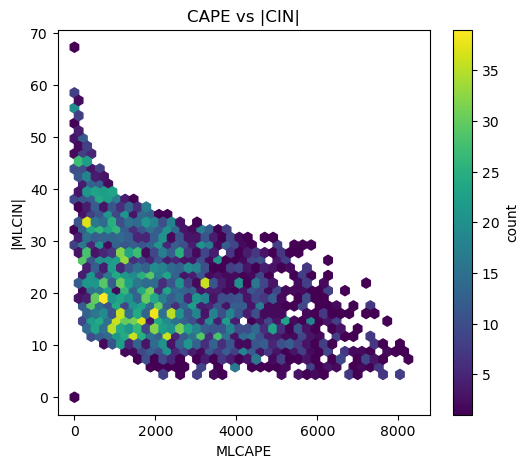

In [6]:
pairs = [
    ('MLCAPE','SH06','CAPE vs 0–6 km shear'),
    ('MLCAPE','SH01','CAPE vs 0–1 km shear'),
    ('MLCAPE','MLCIN','CAPE vs |CIN|'),
]
for x,y,title in pairs:
    if x not in df or y not in df: continue
    xv = df[x].values
    yv = np.abs(df[y].values) if y=='MLCIN' else df[y].values
    plt.figure(figsize=(6,5))
    plt.hexbin(xv, yv, gridsize=40,mincnt=1)
    plt.xlabel(x if x!='MLCIN' else '|MLCIN|')
    plt.ylabel(y if y!='MLCIN' else '|MLCIN|')
    plt.title(title)
    plt.colorbar(label='count')
    plt.show()


## Binned coverage tables (edit bins as needed)

In [7]:
cape_bins = [0, 250, 500, 1000, 2000, 4000, np.inf]
shear_bins = [0, 10, 20, 30, 40, 50, np.inf]
cin_bins = [0, 25, 50, 100, 200, 400, np.inf]

df['CINabs'] = np.abs(df['MLCIN'])
df['CAPE_bin'] = pd.cut(df['MLCAPE'], bins=cape_bins)
df['SH06_bin'] = pd.cut(df['SH06'], bins=shear_bins)
df['CIN_bin']  = pd.cut(df['CINabs'], bins=cin_bins)

pivot_cape_sh06 = df.pivot_table(index='CAPE_bin', columns='SH06_bin', values='idx', aggfunc='count').fillna(0).astype(int)
pivot_cape_cin  = df.pivot_table(index='CAPE_bin', columns='CIN_bin',  values='idx', aggfunc='count').fillna(0).astype(int)
pivot_cape_sh06, pivot_cape_cin

/tmp/ipykernel_2130521/4089206927.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_cape_sh06 = df.pivot_table(index='CAPE_bin', columns='SH06_bin', values='idx', aggfunc='count').fillna(0).astype(int)
/tmp/ipykernel_2130521/4089206927.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_cape_cin  = df.pivot_table(index='CAPE_bin', columns='CIN_bin',  values='idx', aggfunc='count').fillna(0).astype(int)


(SH06_bin          (0.0, 10.0]  (10.0, 20.0]  (20.0, 30.0]  (30.0, 40.0]  \
 CAPE_bin                                                                  
 (0.0, 250.0]               27           103            84            66   
 (250.0, 500.0]             55           162           103            63   
 (500.0, 1000.0]            80           364           287           119   
 (1000.0, 2000.0]          148           599           509           279   
 (2000.0, 4000.0]          215           789           610           292   
 (4000.0, inf]              99           355           264           164   
 
 SH06_bin          (40.0, 50.0]  (50.0, inf]  
 CAPE_bin                                     
 (0.0, 250.0]                13            0  
 (250.0, 500.0]              30            0  
 (500.0, 1000.0]             38            0  
 (1000.0, 2000.0]            69            0  
 (2000.0, 4000.0]           102            0  
 (4000.0, inf]               55            0  ,
 CIN_bin     

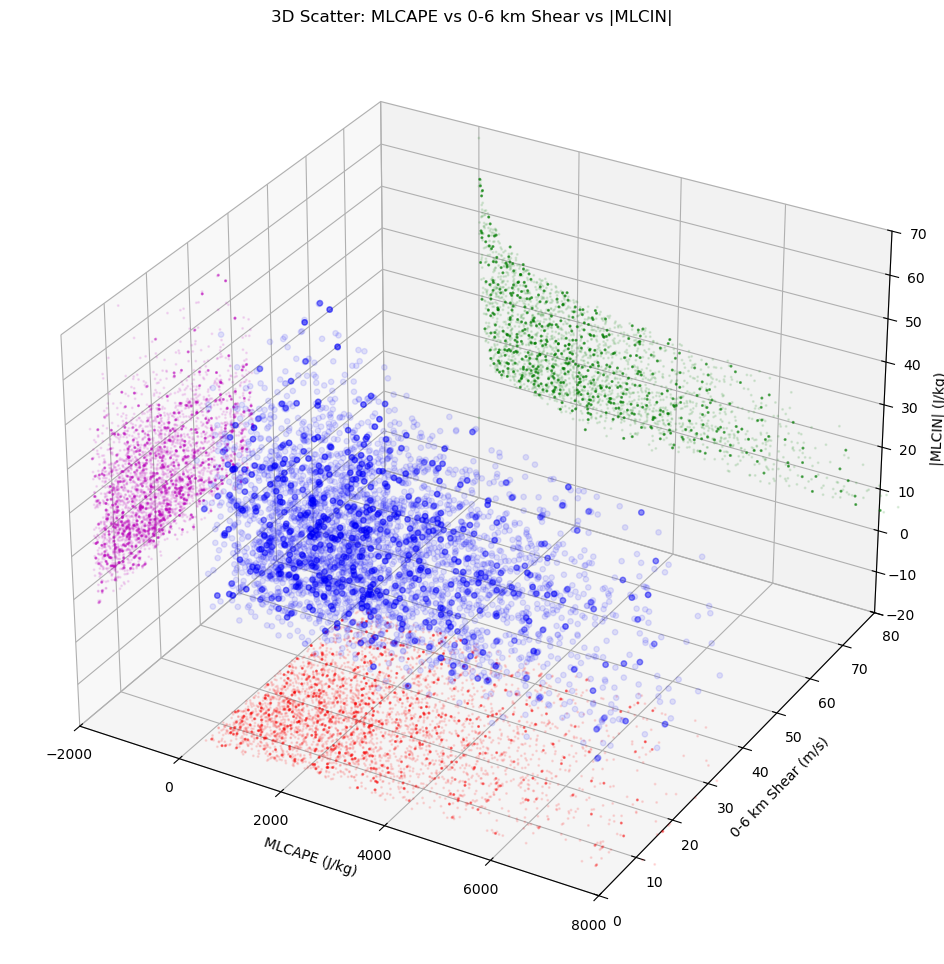

In [8]:
#scatter 3D cape, shear, cin
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['MLCAPE'], df['SH06'], df['CINabs'], c='b', marker='o', s=15, alpha=0.1)
ax.set_xlabel('MLCAPE (J/kg)')
ax.set_ylabel('0-6 km Shear (m/s)')
ax.set_zlabel('|MLCIN| (J/kg)')
ax.set_title('3D Scatter: MLCAPE vs 0-6 km Shear vs |MLCIN|')
ax.set_xlim(-2000, 8000)
ax.set_ylim(0, 80)
ax.set_zlim(-20, 70)
#projection in xy plane
ax.scatter(df['MLCAPE'], df['SH06'], zs=-20, zdir='z', c='r', marker='.', s=5, alpha=0.1)
#projection in xz plane
ax.scatter(df['MLCAPE'], zs=80, zdir='y', ys=df['CINabs'], c='g', marker='.', s=5, alpha=0.1)
#projection in yz plane
ax.scatter(zs=-2000, zdir='x', xs=df['SH06'], ys=df['CINabs'], c='m', marker='.', s=5, alpha=0.1)
plt.show()